# Evaluate your RAG

This notebook aims to evaluate your RAG built with `llama_index`, which uses documents stored in an AWS S3 bucket. The `RAGConfig` class allows you to specify:

- A HuggingFace embedding model
- An LLM available on AWS BedrockChat
- A prompt

You can experiment with different configurations to find the most effective ones. 

Use the `RAGEvaluate` class to assess these configurations using various metrics. Under the hood, `RAGEvaluate` employs `RAGAS`.

Save your results and compare them using the `AnalyzeResults` class to visualize the score distributions across different metrics.


In [1]:
import pandas as pd
import boto3
import s3fs
import nest_asyncio

from Core.rag_config import RAGConfig
from Core.rag_evaluate import RAGEvaluate
from Core.results_analyzer import ResultsAnalyzer

c:\Users\soel.megdoud\Documents\RAG Air Liquide\rag_cs\AWS_RAG_Toolkit\prod_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\soel.megdoud\Documents\RAG Air Liquide\rag_cs\AWS_RAG_Toolkit\prod_venv\lib\site-packages\pydantic\_internal\_fields.py:132: UserWarning: Field "model_id" in BedrockBase has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
c:\Users\soel.megdoud\Documents\RAG Air Liquide\rag_cs\AWS_RAG_Toolkit\prod_venv\lib\site-packages\pydantic\_internal\_fields.py:132: UserWarning: Field "model_kwargs" in BedrockBase has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
c:\Users\s

Import your AWS credentials

In [3]:
import configparser
config = configparser.ConfigParser()
config.read('../aws_credentials.cfg')

aws_access_key_id = config.get('default', 'aws_access_key_id')
aws_secret_access_key = config.get('default', 'aws_secret_access_key')
region_name = config.get('default', 'region_name')

# Session boto3 with credentials
session = boto3.Session(
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name=region_name
)

Your S3 bucket with the documents for the RAG in AWS

In [4]:
s3 = s3fs.S3FileSystem(key=aws_access_key_id, secret=aws_secret_access_key)
s3_bucket_name = "airliquide-alit-gio-aiops-dev/chaima/indexes_md"

In [5]:
nest_asyncio.apply()

## Test different configurations

Examples of HuggingFace embedding models to try:
- "BAAI/bge-small-en-v1.5"
- "avsolatorio/GIST-small-Embedding-v0"
- "avsolatorio/NoInstruct-small-Embedding-v0"

Examples of AWS Bedrock LLM to try:
- "mistral.mistral-large-2402-v1:0"
- "anthropic.claude-3-sonnet-20240229-v1:0"
- "anthropic.claude-v2"


In [10]:
from ragas.metrics import answer_relevancy, faithfulness, context_precision, context_recall

prompt_basic = "You are a chatbot powered by AIops Team called YodaAI, able to have a normal interactions, as well as talk about the CS (Cloud Services) Tech Guides given in the context. The CS Tech Guides is a documentation for CS service employees in GIO (Global Infrastructure Operations) entity in AirLiquide. Introduce yourself based on the presentation in this system prompt if there is not a clear a question. If you can't find the response in the context please return this answer: Unfortunately I don't have any information about [topic of the query] in the context that was provided to me. As an AI assistant without access to external information, I can only discuss the details contained in the CS Tech Guides"

config1 = RAGConfig(name = "mistral_large_avsolatorio_non_instruct_small",
                   generation_llm="mistral.mistral-large-2402-v1:0",
                   embedder="avsolatorio/NoInstruct-small-Embedding-v0",
                   prompt=prompt_basic,
                   scoring_llm="anthropic.claude-3-sonnet-20240229-v1:0",
                   metrics= [faithfulness,answer_relevancy, context_precision, context_recall])

config2 = RAGConfig(name = "claude3_BGE_small",
                   generation_llm="anthropic.claude-3-sonnet-20240229-v1:0",
                   embedder="BAAI/bge-small-en-v1.5",
                   prompt=prompt_basic,
                   scoring_llm="anthropic.claude-3-sonnet-20240229-v1:0",
                   metrics= [faithfulness,answer_relevancy, context_precision, context_recall])

config3 = RAGConfig(name = "claude2_BGE_small",
                   generation_llm="anthropic.claude-v2",
                   embedder="BAAI/bge-small-en-v1.5",
                   prompt=prompt_basic,
                   scoring_llm="anthropic.claude-3-sonnet-20240229-v1:0",
                   metrics= [faithfulness,answer_relevancy, context_precision, context_recall])


## Evaluate your configurations

Import your testset

In [11]:
testset = pd.read_csv('Testsets/RAG_testset_processed.csv')
testset = testset.iloc[:2,:]
testset.head(1)

,Unnamed: 0,question,RAGAS_context,ground_truth,RAGAS_source,evolution_type,index
0,0,What are some key points or best practices typ...,"["" these jobs. To do that, just run the pipeli...",Some key points and best practices typically c...,[{'source': 'cloud-services\\docs\\ningines\\0...,simple,NaN


Evaluate your config with RAGEvaluate and RAGAS

In [12]:
evaluator = RAGEvaluate(config1, session, s3, s3_bucket_name)
await evaluator.evaluate(testset)

Evaluating configuration: mistral_large_avsolatorio_non_instruct_small


c:\Users\soel.megdoud\Documents\RAG Air Liquide\rag_cs\AWS_RAG_Toolkit\prod_venv\lib\site-packages\pydantic\_internal\_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPIEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


Answering questions



c:\Users\soel.megdoud\Documents\RAG Air Liquide\rag_cs\AWS_RAG_Toolkit\prod_venv\lib\site-packages\Core\rag_evaluate.py:188: LangChainDeprecationWarning: The class `BedrockChat` was deprecated in LangChain 0.0.34 and will be removed in 1.0. An updated version of the class exists in the langchain-aws package and should be used instead. To use it run `pip install -U langchain-aws` and import as `from langchain_aws import ChatBedrock`.
  llm4scoring = BedrockChat(
c:\Users\soel.megdoud\Documents\RAG Air Liquide\rag_cs\AWS_RAG_Toolkit\prod_venv\lib\site-packages\Core\rag_evaluate.py:193: LangChainDeprecationWarning: The class `BedrockEmbeddings` was deprecated in LangChain 0.2.11 and will be removed in 1.0. An updated version of the class exists in the langchain-aws package and should be used instead. To use it run `pip install -U langchain-aws` and import as `from langchain_aws import BedrockEmbeddings`.
  embeddings = BedrockEmbeddings(client=bedrock_client)
Evaluating:   0%|          | 

Save the results for benchmark

In [21]:
evaluator.save_results_to_json('Results/Mistral_Large_avsolatorio_non_instruct_small.json')

Results and testset successfully saved to Results/Mistral_Large_avsolatorio_non_instruct_small.json


## Compare your configurations

Load your results

In [23]:
analyzer = ResultsAnalyzer(['Results/Mistral_Large_GIST.json', 'Results/Mistral_Large_avsolatorio_non_instruct_small.json'])

Print report

In [26]:
analyzer.report(threshold_dict={'faithfulness':0.9})

==================== Mistral_Large_GIST ============
Average faithfulness: 0.90
20 questions (64.52%) exceeded the threshold of 0.9 for faithfulness
Average answer_relevancy: 0.87
Average context_precision: 0.65
Average context_recall: 0.75


==================== Mistral_Large_avsolatorio_non_instruct_small 
Average faithfulness: 0.90
21 questions (67.74%) exceeded the threshold of 0.9 for faithfulness
Average answer_relevancy: 0.87
Average context_precision: 0.58
Average context_recall: 0.79




Show heatmaps

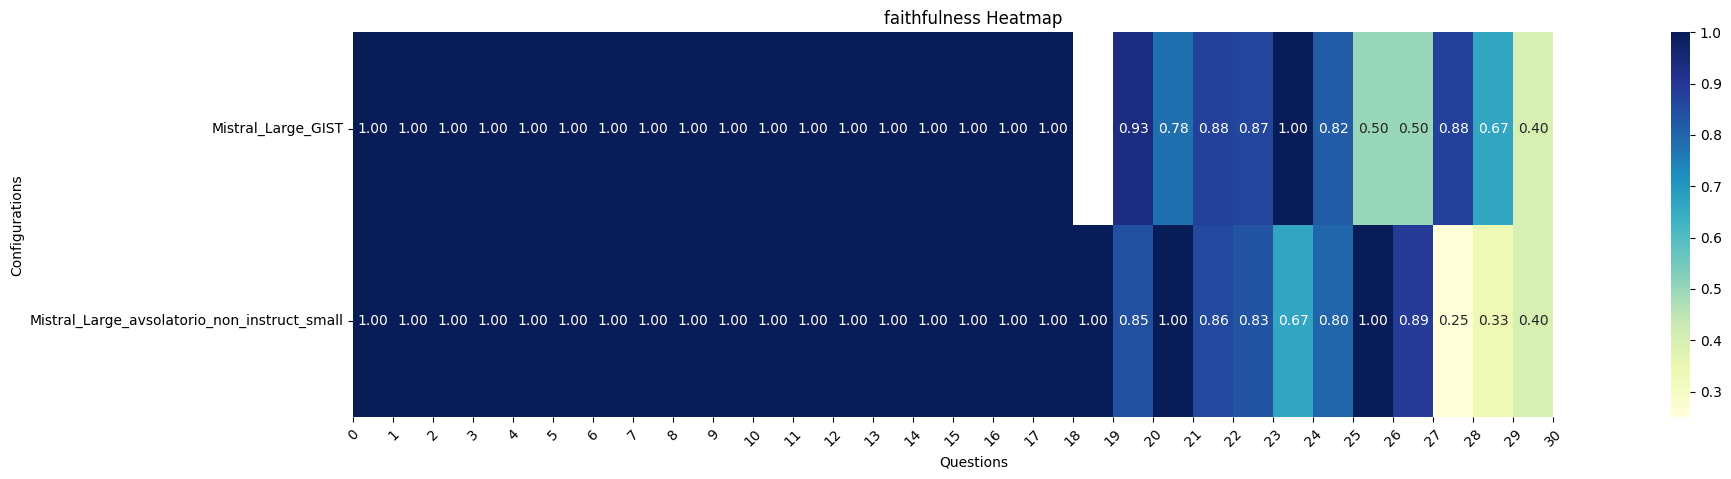

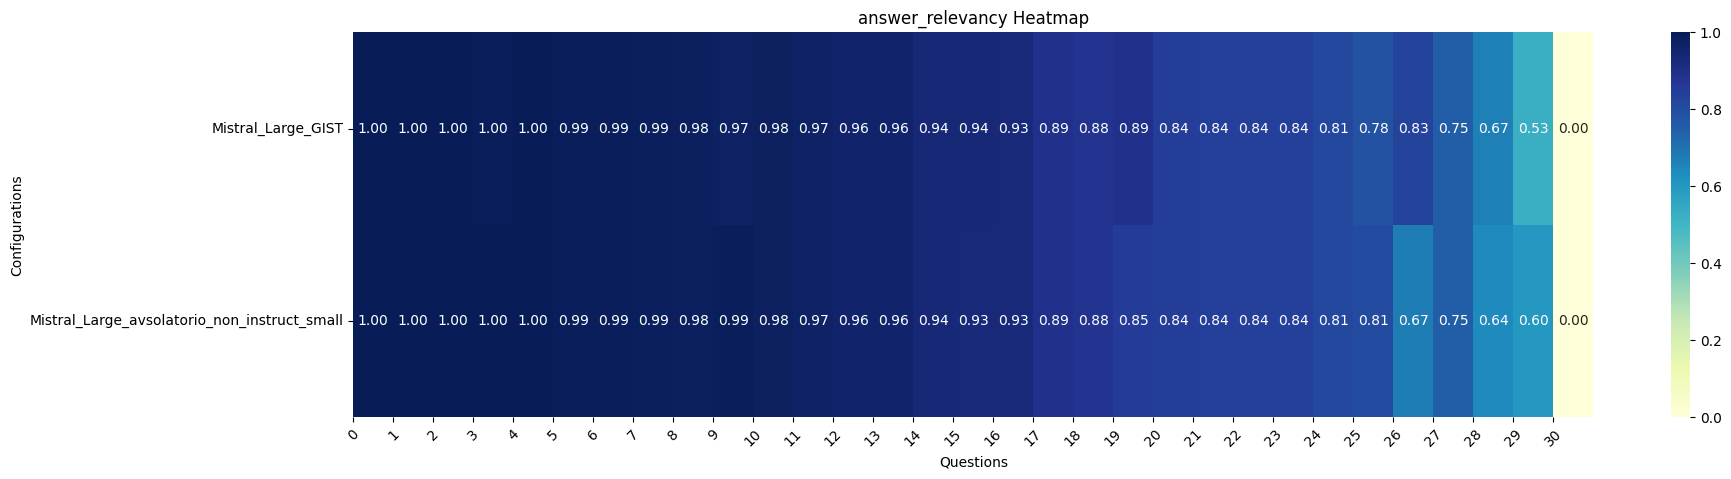

In [25]:
analyzer.show_heatmap(metric='faithfulness')
analyzer.show_heatmap(metric='answer_relevancy')

Plot barplots

c:\Users\soel.megdoud\Documents\RAG Air Liquide\rag_cs\AWS_RAG_Toolkit\prod_venv\lib\site-packages\Core\results_analyzer.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='File', y='Average Score', data=df_plot[df_plot['Metric'] == metric], palette='viridis')


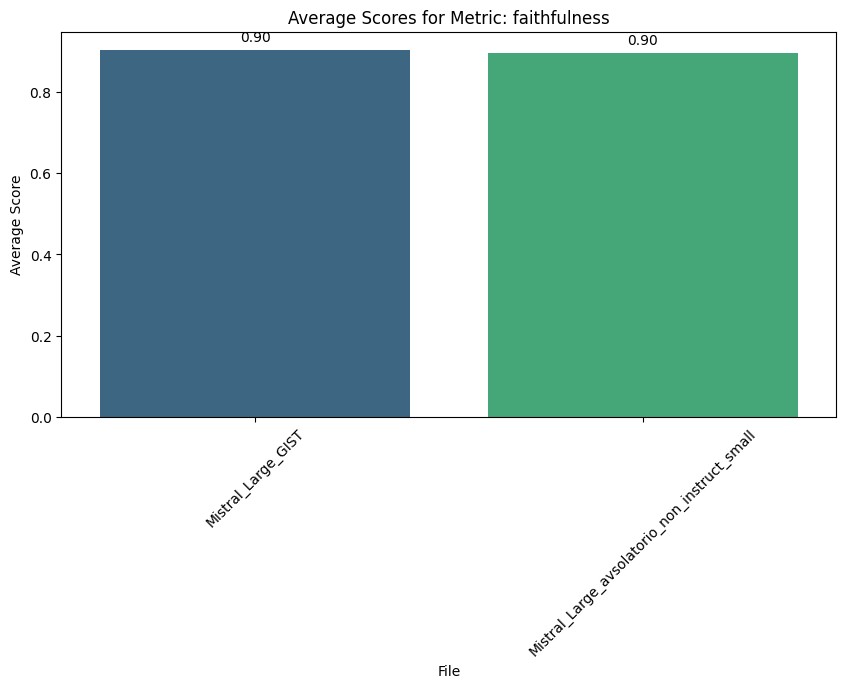

c:\Users\soel.megdoud\Documents\RAG Air Liquide\rag_cs\AWS_RAG_Toolkit\prod_venv\lib\site-packages\Core\results_analyzer.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='File', y='Average Score', data=df_plot[df_plot['Metric'] == metric], palette='viridis')


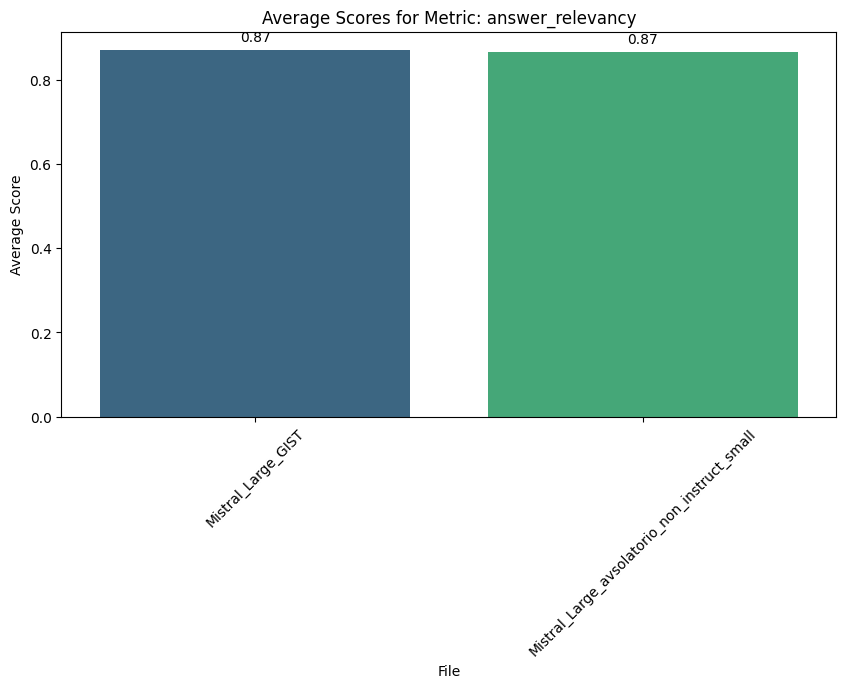

c:\Users\soel.megdoud\Documents\RAG Air Liquide\rag_cs\AWS_RAG_Toolkit\prod_venv\lib\site-packages\Core\results_analyzer.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='File', y='Average Score', data=df_plot[df_plot['Metric'] == metric], palette='viridis')


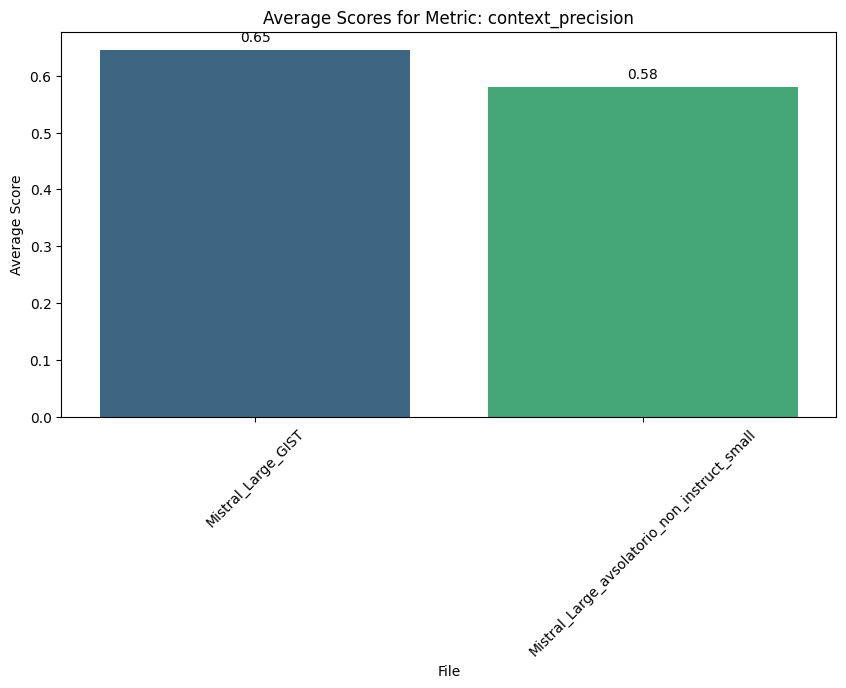

c:\Users\soel.megdoud\Documents\RAG Air Liquide\rag_cs\AWS_RAG_Toolkit\prod_venv\lib\site-packages\Core\results_analyzer.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='File', y='Average Score', data=df_plot[df_plot['Metric'] == metric], palette='viridis')


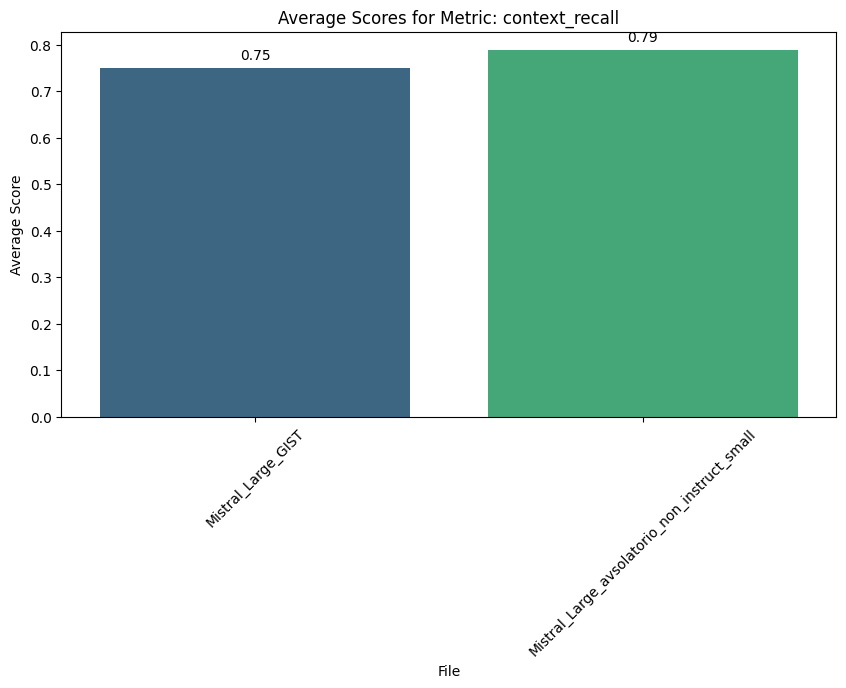

In [27]:
analyzer.barplot()